<a href="https://colab.research.google.com/github/cyrus2281/notes/blob/main/MachineLearning/Tensorflow/LazyProgrammer/03_Tensorflow_Advanced_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

>[Content](#scrollTo=8-RJemp6Yly-)

>[Transfer Learning](#scrollTo=j_FKFwPecfPt)

>>[Python Implementation](#scrollTo=AowNHE5OfsoL)

>[GAN](#scrollTo=SDWZ_rhRobyK)

>>[The Loss Functions](#scrollTo=5ikg6K2PpjhB)

>>[GAN Architecture](#scrollTo=VzGhNx9srAul)

>>[Python Implementation](#scrollTo=I6oSv-GEvYau)



# Transfer Learning

The features that were found from one task may be useful for another task.

In CNN, the initial layers are simple generic lines and strokes.

We get the pre-trained model, chop off the head, and add our own classifier layer. We'd also need to freeze the other layers.


## Python Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
# Data from : https://mmspg.epfl.ch/downloads/food-image-datasets/
!wget --passive-ftp --prefer-family=ipv4 --ftp-user datasets@mmspgdata.epfl.ch \
 --ftp-password ohsh9jah4T -nc ftp://tremplin.epfl.ch/FoodImage/Food-5K.zip

--2023-12-21 04:08:28--  ftp://tremplin.epfl.ch/FoodImage/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.218.41, 2001:620:618:1da:7:80b2:da01:3
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.218.41|:21... connected.
Logging in as datasets@mmspgdata.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /FoodImage ... done.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M  3.84MB/s    in 1m 53s  

2023-12-21 04:10:23 (3.78 MB/s) - ‘Food-5K.zip’ saved [446919921]



In [ ]:
!unzip -qq -o Food-5K.zip

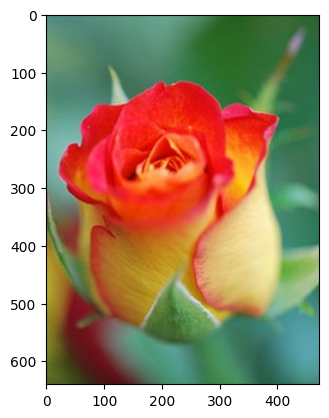

In [ ]:
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

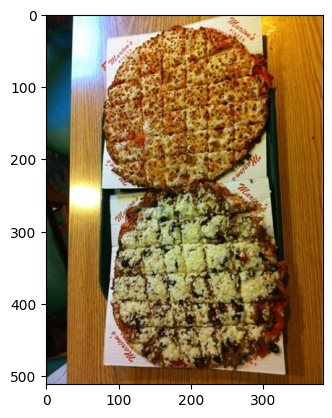

In [ ]:
# Food Image start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [ ]:
# Make dir to store the data Keras-style
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [ ]:
# Move the images
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [ ]:
train_path = 'data/train'
valid_path = 'data/test'

# These images are pretty big and of different sizes
# Let's load them all in the same (smaller) size
IMAGE_SIZE = [200, 200]

# Useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

# Useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

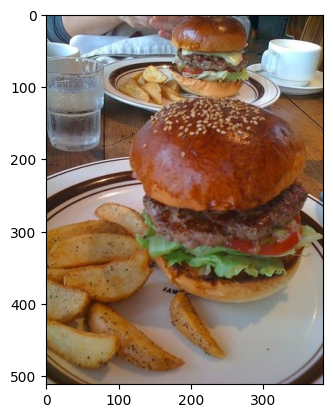

In [ ]:
# Look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3], # 3 is number of color channels
    weights='imagenet',
    include_top=False
)

ptm.trainable = False

In [ ]:
# Map the data into feature vector
K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation="softmax")(x)

# Create a model object
model = Model(inputs=ptm.input, outputs=x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [ ]:
# Create  an intance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)


batch_size = 128

# Create generator
train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
)
valid_generator=gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
24/24 [==============================] - 95s 3s/step - loss: 2.6108 - accuracy: 0.8947 - val_loss: 0.8288 - val_accuracy: 0.9610
Epoch 2/10
24/24 [==============================] - 52s 2s/step - loss: 0.7385 - accuracy: 0.9720 - val_loss: 0.6907 - val_accuracy: 0.9680
Epoch 3/10
24/24 [==============================] - 52s 2s/step - loss: 0.3055 - accuracy: 0.9823 - val_loss: 0.9132 - val_accuracy: 0.9630
Epoch 4/10
24/24 [==============================] - 52s 2s/step - loss: 0.2310 - accuracy: 0.9850 - val_loss: 0.7473 - val_accuracy: 0.9680
Epoch 5/10
24/24 [==============================] - 52s 2s/step - loss: 0.1682 - accuracy: 0.9903 - val_loss: 0.8582 - val_accuracy: 0.9680
Epoch 6/10
24/24 [==============================] - 59s 2s/step - loss: 0.1790 - accuracy: 0.9893 - val_loss: 0.6314 - val_accuracy: 0.9620
Epoch 7/10
24/24 [==============================] - 52s 2s/step - loss: 0.1488 - accuracy: 0.9927 - val_loss: 0.7633 - val_accuracy: 0.9690
Epoch 8/10
24/24 [==

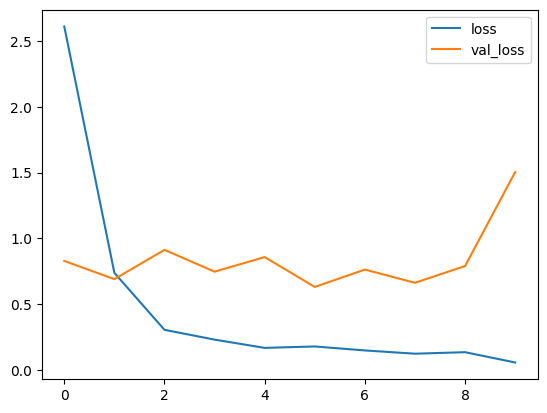

In [ ]:
# Plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

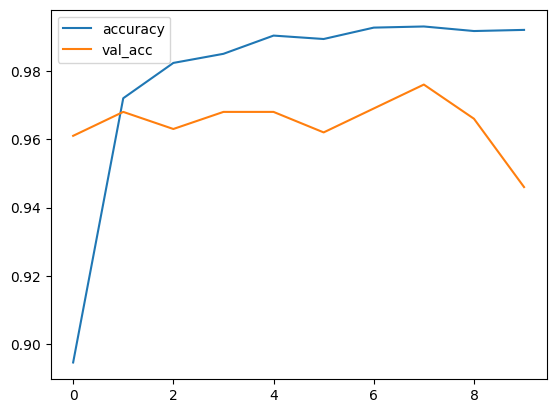

In [ ]:
# Plot accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# GAN

Generative adversarial networks (GAN).

GANs are used to generate data. (Specifically images)

GANs have 2 system
- generator: to generate real images
- discriminator: to detect fake images


We'd need 2 neural networks, and an objective/loss function to minimize.



## The Loss Functions



**Discriminator loss function:**

This is a binary classification problem. real or fake.

The correct loss function would be **binary cross entropy**

$$
J_D = - \frac{1}{N} \sum_{n=1}^N \{ y_n \log \hat y_n + (1- y_n) \log (1-\hat y_n) \}
$$

**Generator loss function:**

Freeze the discriminator layers so only the generator is trained.

Continue using binary cross entropy (eg real=1, fake=0)

Simply pass in fake images, but use 1 for the label.

$$
J_G = - \frac{1}{N} \sum_{n=1}^N  \log \hat y_n, \hat y_n = \text{fake image, target is always 1}
$$

Output probability of real given fake image

## GAN Architecture

Noise → Generator → Fake Image

Image → Discriminator → Real/Fake

\

**Pseudocode**

1. Load in the data (image, label)

```python
x,y = get_mnist()
```

2. Create networks

```python
d = Model(image, prediction)
d.compile(loss="binary_cross_entropy",...) # 1 for real, 0 for fake
g = Model(noise,image)
```

3. Combine 'd' and 'g'

```python
fake_prediction = d(g(noise))
combined_model = Model(noise, fake_prediciton)
combined_model.compile(loss='binary_cross_entropy', ...) # 1 is always target
```

4. Gradient descent loop

```python
for epoch in epochs:
  # train discriminator
  real_images = sample from x
  fake_images = g.predict(noise)
  d.train_on_batch(real_images, ones)
  d.train_on_batch(fake_images, zeros)

  # train generator
  combined_model.train_on_batch(noise, ones)
```




The discriminator and generator are constantly trying to 'one-up' each other.

So loss or accuracy doesn't make much sense, because they are improving at the same rate.



**Summary**

- A GAN isn't just a single neural network, but a system of 2 neural networks: generator and discriminator
- They learn in tandem
- Discriminator loss: binary cross entropy
- Generator loss: binary cross entropy on the combined model
  - Freeze the discriminator in the combined model
  - Flip the labels (images from generator are labeled as real)
- Generator input is noise, sampled from latent space
- Latent space is like the opposite of feature transformation/embedding
- Embedding/feature: input image/text/etc. → vector
- Generator: vector/feature/embedding → image
- Loss per iteration shouldn't necessarily decrease over time


## Python Implementation

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Map imputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape: ", x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape:  (60000, 28, 28)


In [3]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [4]:
# Dimensionality of the latent space
latent_dim = 100

In [5]:
# Get genarator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [6]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [7]:
# Compile both models preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile th ecombined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

In [8]:
# Train the GAN

# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every sample_period steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generate images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [9]:
# A function to the generate a grid of random samples from the generator
# and save them to file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise, verbose="")

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" %epoch)
  plt.close()

In [ ]:
# Main training loop
for epoch in range(epochs):
  # Train dicriminator

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise, verbose="")

  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


  # Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 1000 == 0:
    print(f"epoch: {epoch+1} / {epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1 / 30000, d_loss: 0.65, d_acc: 0.53, g_loss: 0.82
epoch: 1001 / 30000, d_loss: 0.63, d_acc: 0.62, g_loss: 0.78
epoch: 2001 / 30000, d_loss: 0.57, d_acc: 0.77, g_loss: 0.97
epoch: 3001 / 30000, d_loss: 0.63, d_acc: 0.59, g_loss: 0.99
epoch: 4001 / 30000, d_loss: 0.58, d_acc: 0.69, g_loss: 1.02
epoch: 5001 / 30000, d_loss: 0.64, d_acc: 0.67, g_loss: 0.99
epoch: 6001 / 30000, d_loss: 0.61, d_acc: 0.64, g_loss: 1.14
epoch: 7001 / 30000, d_loss: 0.61, d_acc: 0.70, g_loss: 1.06
epoch: 8001 / 30000, d_loss: 0.64, d_acc: 0.56, g_loss: 0.95


In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/29000.png')
plt.imshow(a)

# Reinforcement Learning

- Supervised Learning (SL) is a static function
- Reinforcement learning (RL) is more like a loop
- RL wants to achieve a goal, and can plan for the future
- RL uses goals rather than target

## Reinforcement Learning Terminology

- **Agent**: The model/computer program
- **Environment**: The world
- **Goal**: The Objective
- **Episode**: Each complete round of training (A game/round/match)
- **State**: Input from the environment
- **Terminal State**: Last state of an episode
- **Action**: The action an agent makes
- **Reward**: a number received at each time to evaluate agent behaviour
- **Policies**: What the agent uses to determine what action to perform (given a state)
- **State Space**: set of all possible states
- **Action Space**: set of all possible actions

## State

States can be **discrete** or **continuous**.

Discrete example:
  -  Tic-tac-toe: state is a specific configuration of the board
Continuous example:
  - Robot with sensors: camera, microphone, gyroscope, gps, etc.


Number of targets: Number of states minus one: $0-|S|-1$

If targets are continuous:
- Store them in a vector
- images are stored in tensors
  - In RL, generally, state will be stored as a tensor with 1 or more dimensions.

## Policies

Policy yields an action given only the current state.

Does not use any combination of past states or any rewards.

The state theoretically could be made of past obeservations or rewards, but the latter is unconventional.

**Think policy as  a function or mapping**
- input is the state s (dictionary key)
- Output is an action a (dictionary value)

This approach is somewhat limited if we have an infinite state space.

Agent must try new things to build intuition, thus makes sense for policies to be stochastic (random)

It's better to represent policies as *probabilities*.




- Continuous state spaces: s is a D-dimensional vector
- Policy parameters: W (shape of W is D × |A| )

$$
\pi(a|s) = \text{softmax}(W^Ts) \\
$$

- π: Policy
- a: action, A: action space
- s: state, S: state space


For a given state, we can calculate a probability distribution over the action space, π(a|s). To decide we action to perform in the environment, we can sample from this distribution. We can also use this function deterministicly by using the argmax.

We can use any function approximater.

In RL, an agent can learn to plan for the future by gaining experience.

Instead of an explicit target, it will try to maximize future rewards.

### Epsilon Greedy Policy

One method of using policy as probability is epsilon-greedy, which allows the agent to have a degree of randomness. If a random value is less than some ϵ, we'd take a random action, otherwise we refer to the fixed policy.


## Markov Decision Process

Markov models indicate that the probability of the current state only depends on it's previous state.

$$
p(s_t | s_{t-1}, s_{t-2}, \cdots, s_0) = p(s_t |s_{t-1})
$$


A Markov Decision Process (MDP) describes a reinforcement learning.

We defined the Markov assumption in terms of state only. In an MDP, we describe the environment with the **state-transition probability**.

$$
p(S_{t+1}, R_{t+1} | S_t, A_t) \text{  or  } p(s',r|s,a) \\
$$

Given state s and action a, what's the probability of state s' and reward r.

### State-Transition

- p(s',r | s,a) is the most general
- But sometimes (e.g. a maze example) the reward is deterministic
- No need to model it with probability

\

State transition probability: $p(s' | s,a)$

Reward function: $R(s,a,s')$ or simply $R(s), R(s')$

\

In complex games (e.g. Breakout on Atari) the state space is infeasible to enumerat.
In algorithms such as Q-Learning, state-transition is not used at all.

